<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Performance_Experiments_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Experiments v2
This notebook will look at the effect of customisations against performance. How can we customise models and training algorithms without losing the performance benefits of TensorFlow, GPUs, and the computation graph?

See:
* https://www.tensorflow.org/tutorials/customization/basics
* https://www.tensorflow.org/tutorials/customization/custom_layers
* https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing
* https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough


Past experiments:
* Custom PolynomialFunction (see: OneDrive/Documents/Education/2024-05-03%20Machine%20Learning%20Specialization/Code/Play%20-%20Polynomial_Gradient_Descent.html)
  * One of my earliest experiments. I remember this being slower than I expected.
* Machine Learning Specialization - C2 W2 Collaborative RecSys Assignment. See code in Learning Notes page.
  * I think this was an example that ran slow.
* Capturing weight change directions, in order to plot
  * I had started on this, and it was causing training slow-down. But I seem to have lost that notebook.

Further experiments to try:
* Capturing timing information. eg: https://stackoverflow.com/questions/54527760/using-tensorflow-how-do-i-find-the-time-taken-for-an-epoch-during-fitting

Let's start with some customizations as per the training guides.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
from datetime import datetime

## Reference
A simple model without any customisations.

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [19]:
# To speed up our experiments, just pick the first 5000
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:5000]
y_test = y_test[:5000]

In [20]:
# reshape to (60000, 28*28)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2]).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]).astype("float32") / 255
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (5000, 784)
y_train: (5000,)
x_test: (5000, 784)
y_test: (5000,)


In [26]:
# First, some helper methods
# (timingcallback is defined later on)
def plot_history(history, timingcallback=None, **kwargs):
  timings_quantity = kwargs.get('timings_quantity', 'epoch_per_step');

  loss = history.history['loss']
  times = None
  plt_count = 1

  if timingcallback is not None:
    plt_count += 1
    times = timingcallback.timings[timings_quantity]

  plt.figure(layout='constrained')
  plt.subplot(1,plt_count,1)
  plt.plot(loss)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.yscale('log')

  if times is not None:
    plt.subplot(1,plt_count,2)
    if timings_quantity == 'epoch_per_step' or timings_quantity == 'step':
      plt.plot(times * 1000)
      plt.ylabel(f"{timings_quantity} ms/step")
    else:
      plt.plot(times)
      plt.ylabel(f"{timings_quantity} secs")
    plt.title('Training Times')
    plt.xlabel('Epoch')

  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_interval == 0:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

In [21]:
# This took about 30s to run.
# Notice: 3-6ms/step, or 0-2s per epoch.
model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(28, 28)), # we're pre-flattening
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 0.8373 - accuracy: 0.7080
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.5273 - accuracy: 0.8228
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4707 - accuracy: 0.8412
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 0.4254 - accuracy: 0.8552
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 0.3982 - accuracy: 0.8638
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8662
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 0.3443 - accuracy: 0.8796
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3268 - accuracy: 0.8874
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3076 - accuracy: 0.8918
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - loss: 0.2964 - accuracy: 0.8948

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

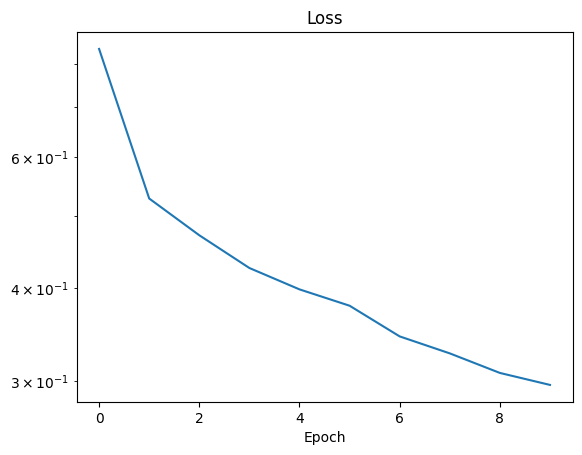

In [23]:
plot_history(history)

## Timing Callback
Because we're interested in timing information, our first customisation will be to collect timing information for plotting.

See: https://www.tensorflow.org/guide/keras/writing_your_own_callbacks

Also note that the calls proceed as follows during training:
```
set_params({'epochs': <num of epochs>, 'steps': <num of batches per epoch>})
on_train_begin(logs=None)
  on_epoch_begin(epoch=#, logs=None)          - for epoch=0..E
    on_train_batch_begin(batch=#, logs=None)  - for batch=0..B
    on_train_batch_end(batch=#, logs={'loss', ...other metrics...})
  on_epoch_end(epoch=#, logs={'loss', ...other metrics...}) - with logs from last batch
on_train_end(logs={'loss', ...other metrics...}) - with logs from last epoch
```

In [6]:
from datetime import datetime

# Note that the keras implementation uses plenty of Python/NumPy without any @tf.function considerations.
# And my own experiments have shown that this callback is called eagerly.
# (source: keras src > keras.callbacks.py)
# (or:     tensorflow src > tensorflow > python > keras.callbacks.py)
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_count = None
        self.step_count = None
        self.start = None
        self.last_epoch = None
        self.last_step = None

        # all units in seconds
        self.timings = {
            'epoch': [],              # |epochs|
            'epoch_per_step': [],     # |epochs|
            'epoch_accumulated': [],  # |epochs|
            'step': []                # |epochs * steps|
        }
    def set_params(self, params):
        # gets params like: {'verbose': 1, 'epochs': 10, 'steps': 157}
        self.epoch_count = params['epochs']
        self.step_count = params['steps']
    def on_train_begin(self, logs=None):
        now = tf.timestamp()
        self.start = now
        self.last_epoch = now
        self.last_step = now
    def on_train_batch_end(self, batch, logs=None):
        now = tf.timestamp()
        dur = (now - self.last_step).numpy()
        self.timings['step'].append(dur)
        self.last_step = now
    def on_epoch_end(self, epoch, logs = {}):
        now = tf.timestamp()
        dur = (now - self.last_epoch).numpy()
        full_dur = (now - self.start).numpy()
        self.timings['epoch'].append(dur)
        self.timings['epoch_per_step'].append(dur / self.step_count)
        self.timings['epoch_accumulated'].append(full_dur)
        #print(f"Epoch {epoch+1}: {dur:.2f}s - {dur/self.step_count * 1000: 0.2f}ms/step")
        self.last_epoch = now
    def on_train_end(self, logs=None):
        # convert data into numpy arrays for easier usage
        for k in self.timings.keys():
            self.timings[k] = np.array(self.timings[k])

In [142]:
# Example output
#  Epoch 1/10
#  157/157 [==============================] - 1s 4ms/step - loss: 0.8355 - accuracy: 0.7160
#  Epoch 2/10
#  157/157 [==============================] - 1s 7ms/step - loss: 0.5347 - accuracy: 0.8088
#  Epoch 3/10
#  157/157 [==============================] - 1s 6ms/step - loss: 0.4647 - accuracy: 0.8372
#  Epoch 4/10
#  157/157 [==============================] - 1s 6ms/step - loss: 0.4177 - accuracy: 0.8594
#  Epoch 5/10
#  157/157 [==============================] - 1s 5ms/step - loss: 0.3896 - accuracy: 0.8656
#  Epoch 6/10
#  157/157 [==============================] - 1s 4ms/step - loss: 0.3712 - accuracy: 0.8714
#  Epoch 7/10
#  157/157 [==============================] - 0s 3ms/step - loss: 0.3501 - accuracy: 0.8760
#  Epoch 8/10
#  157/157 [==============================] - 1s 3ms/step - loss: 0.3457 - accuracy: 0.8776
#  Epoch 9/10
#  157/157 [==============================] - 0s 3ms/step - loss: 0.3123 - accuracy: 0.8874
#  Epoch 10/10
#  157/157 [==============================] - 1s 3ms/step - loss: 0.2868 - accuracy: 0.9008
model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(28, 28)), # we're pre-flattening
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10, callbacks = [timings])

Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 0.8068 - accuracy: 0.7246
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.5391 - accuracy: 0.8176
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4807 - accuracy: 0.8290
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4204 - accuracy: 0.8562
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3910 - accuracy: 0.8686
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 0.3719 - accuracy: 0.8746
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3518 - accuracy: 0.8770
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3250 - accuracy: 0.8868
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3027 - accuracy: 0.8990
Epoch 10/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2866 - accuracy: 0.9036

In [67]:
print(f"keys: {timings.timings.keys()}")
for k in timings.timings.keys():
    print(f"  {k}: {len(timings.timings[k])}")


keys: dict_keys(['epoch', 'epoch_per_step', 'epoch_accumulated', 'step'])
  epoch: 10
  epoch_per_step: 10
  epoch_accumulated: 10
  step: 1570


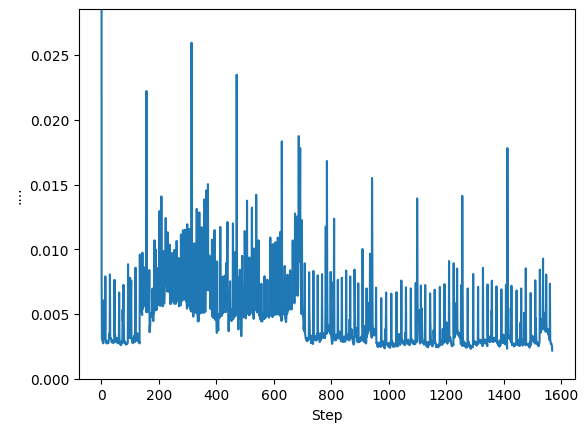

In [81]:
# when plotting steps, the very first one always has an extra high value, so need to manually calculate a better maxy
steps_max_y = max(timings.timings['step'][1:]) * 1.1
plt.ylim(0, steps_max_y)
plt.xlabel('Step')
plt.ylabel('....')
plt.plot(timings.timings['step'])
plt.show()

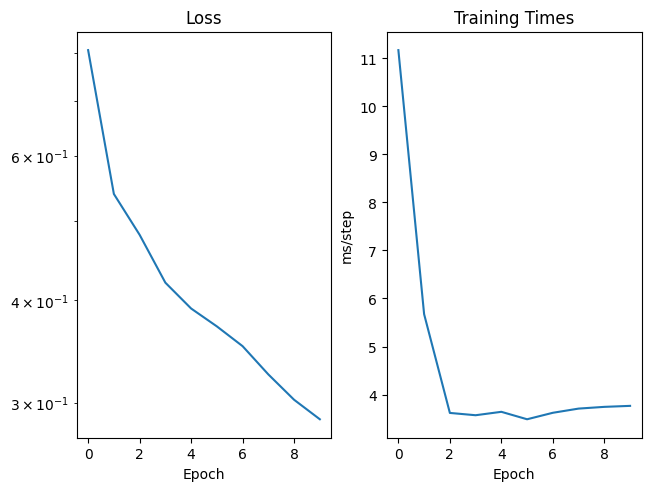

In [143]:
plot_history(history, timings)

## Custom Layer
Now, based on the approach suggested in the following tutorial, let's experiment with a custom layer and see how that affects performance.
* https://www.tensorflow.org/tutorials/customization/custom_layers

In [88]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]), self.num_outputs])

  def call(self, inputs):
    print(f"MyDenseLayer called")
    return tf.matmul(inputs, self.kernel)

layer = MyDenseLayer(10)

Epoch 1/10
MyDenseLayer called
MyDenseLayer called
MyDenseLayer called
157/157 [==============================] - 1s 4ms/step - loss: 0.8153 - accuracy: 0.7258
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.5299 - accuracy: 0.8198
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.4689 - accuracy: 0.8404
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4220 - accuracy: 0.8570
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3997 - accuracy: 0.8602
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3572 - accuracy: 0.8800
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3429 - accuracy: 0.8798
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3167 - accuracy: 0.8902
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3088 - accuracy: 0.8948
Epoch 10/10
157/157 [===================

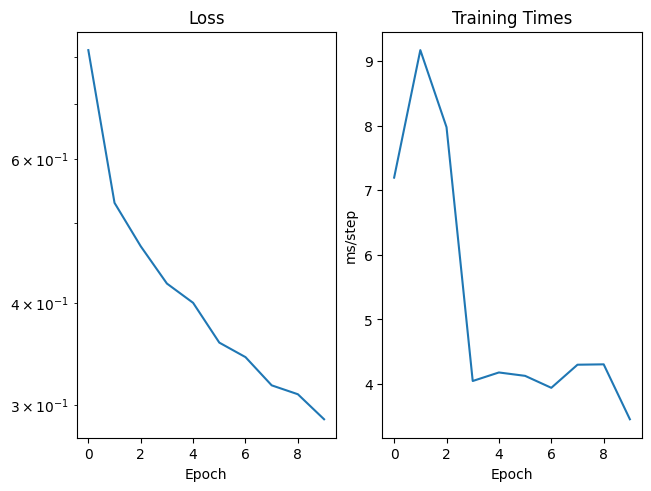

In [89]:
model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(28, 28)), # we're pre-flattening
    tf.keras.layers.Dense(128, activation='relu'),
    MyDenseLayer(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10, callbacks = [timings])
plot_history(history, timings)

Notice that the custom layer was invoked within a computation graph, as indicated by the fact that its print statement only got called three times.

Also, the timings so far seem comparable with an out-of-box model.

## Manual training loop
Go jump to the other extreme and create our own training loop.

With inspiration from:
* https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing
* "OneDrive\Documents\Education\2024-05-03 Machine Learning Specialization\Code\C3_W2_Collaborative_RecSys_Assignment.html"


In [132]:
# This implementation doesn't use any @tf.function and takes about 40s to run:
#  Epoch 1 - 4.2s - loss: 0.470 - accuracy: 0.725
#  Epoch 2 - 3.6s - loss: 0.232 - accuracy: 0.772
#  Epoch 3 - 4.3s - loss: 0.145 - accuracy: 0.794
#  Epoch 4 - 10.2s - loss: 0.099 - accuracy: 0.809
#  Epoch 5 - 3.6s - loss: 0.067 - accuracy: 0.820
#  Epoch 6 - 5.1s - loss: 0.048 - accuracy: 0.830
#  Epoch 7 - 3.8s - loss: 0.040 - accuracy: 0.837
#  Epoch 8 - 3.4s - loss: 0.029 - accuracy: 0.844
#  Epoch 9 - 5.1s - loss: 0.024 - accuracy: 0.850
#  Epoch 10 - 3.6s - loss: 0.022 - accuracy: 0.856

# mirroring the defaults that would otherwise happen out-of-box:
#  batch_size=32
def train(model, x_train, y_train, **kwargs):
  epochs = kwargs.get('epochs')
  batch_size = kwargs.get('batch_size', 32)
  optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam(learning_rate=1e-3))
  loss_fn = kwargs.get('loss')
  accuracy_metric_fn = kwargs.get('accuracy', tf.keras.metrics.Accuracy())
  callbacks_list = kwargs.get('callbacks', [])

  # prepare
  history = tf.keras.callbacks.History()
  callbacks_list.append(history)
  callbacks = tf.keras.callbacks.CallbackList(callbacks_list, model=model)

  batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

  # start
  callbacks.set_params({'verbose': 1, 'epochs': epochs, 'steps': len(batches)})

  # train
  logs = {}
  callbacks.on_train_begin()
  for epoch in range(epochs):
    start = tf.timestamp()
    callbacks.on_epoch_begin(epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(batches):
      #print(f"  Step {step+1}: x_batch_train: {x_batch_train.shape}, y_batch_train: {y_batch_train.shape}")
      callbacks.on_train_batch_begin(step)
      with tf.GradientTape() as tape:
        y_batch_pred = model(x_batch_train)
        loss = loss_fn(y_batch_train, y_batch_pred)
      accuracy = accuracy_metric_fn(y_batch_train, np.argmax(y_batch_pred,axis=1))
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      logs = {'loss': loss, 'accuracy': accuracy}
      callbacks.on_train_batch_end(step, logs)

    # end of epoch
    dur = (tf.timestamp() - start).numpy()
    callbacks.on_epoch_end(epoch, logs) # should be passing loss and mse
    print(f"Epoch {epoch+1} - {dur:.1f}s - loss: {logs['loss']:.3f} - accuracy: {logs['accuracy']:.3f}")
  callbacks.on_train_end(logs)

epochs = 10
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
])
timings = timecallback()
train(model, x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss=loss_fn, callbacks=[timings])

Epoch 1 - 4.2s - loss: 0.470 - accuracy: 0.725
Epoch 2 - 3.6s - loss: 0.232 - accuracy: 0.772
Epoch 3 - 4.3s - loss: 0.145 - accuracy: 0.794
Epoch 4 - 10.2s - loss: 0.099 - accuracy: 0.809
Epoch 5 - 3.6s - loss: 0.067 - accuracy: 0.820
Epoch 6 - 5.1s - loss: 0.048 - accuracy: 0.830
Epoch 7 - 3.8s - loss: 0.040 - accuracy: 0.837
Epoch 8 - 3.4s - loss: 0.029 - accuracy: 0.844
Epoch 9 - 5.1s - loss: 0.024 - accuracy: 0.850
Epoch 10 - 3.6s - loss: 0.022 - accuracy: 0.856


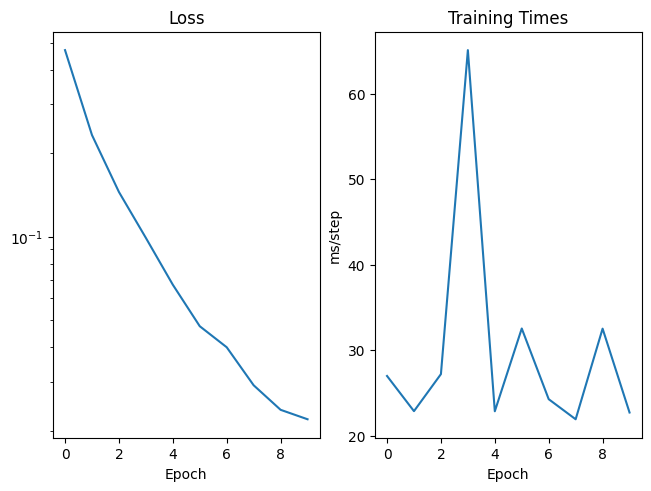

In [133]:
plot_history(history, timings)

Let's now try adding @tf.function to it.

This seems to get us back to the same timeliness as the out-of-box model.

Failures not shown:
* `@tf.function` around entire `train()` method fails because all the callback logic isn't AutoGraph compatible. After looking at the out-of-box Model code (see below), I reduced the scope of the `@tf.function`.

In [140]:
@tf.function
def train_step(model, x_batch_train, y_batch_train, optimizor, loss_fn, accuracy_metric_fn):
  with tf.GradientTape() as tape:
    y_batch_pred = model(x_batch_train)
    loss = loss_fn(y_batch_train, y_batch_pred)
  accuracy = accuracy_metric_fn(y_batch_train, tf.argmax(y_batch_pred,axis=1))  # was np.argmax() but that caused errors
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return (loss, accuracy)

def train(model, x_train, y_train, **kwargs):
  epochs = kwargs.get('epochs')
  batch_size = kwargs.get('batch_size', 32)
  optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam(learning_rate=1e-3))
  loss_fn = kwargs.get('loss')
  accuracy_metric_fn = kwargs.get('accuracy', tf.keras.metrics.Accuracy())
  callbacks_list = kwargs.get('callbacks', [])

  # prepare
  history = tf.keras.callbacks.History()
  callbacks_list.append(history)
  callbacks = tf.keras.callbacks.CallbackList(callbacks_list, model=model)

  batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

  # start
  callbacks.set_params({'verbose': 1, 'epochs': epochs, 'steps': len(batches)})

  # train
  logs = {}
  callbacks.on_train_begin()
  for epoch in range(epochs):
    start = tf.timestamp()
    callbacks.on_epoch_begin(epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(batches):
      #print(f"  Step {step+1}: x_batch_train: {x_batch_train.shape}, y_batch_train: {y_batch_train.shape}")
      callbacks.on_train_batch_begin(step)
      (loss, accuracy) = train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, accuracy_metric_fn)
      logs = {'loss': loss, 'accuracy': accuracy}
      callbacks.on_train_batch_end(step, logs)

    # end of epoch
    dur = (tf.timestamp() - start).numpy()
    callbacks.on_epoch_end(epoch, logs) # should be passing loss and mse
    print(f"Epoch {epoch+1} - {dur:.1f}s - loss: {logs['loss']:.3f} - accuracy: {logs['accuracy']:.3f}")
  callbacks.on_train_end(logs)

epochs = 10
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
])
timings = timecallback()
train(model, x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss=loss_fn, callbacks=[timings])

Epoch 1 - 2.6s - loss: 0.373 - accuracy: 0.724
Epoch 2 - 1.3s - loss: 0.223 - accuracy: 0.771
Epoch 3 - 0.6s - loss: 0.141 - accuracy: 0.795
Epoch 4 - 0.5s - loss: 0.110 - accuracy: 0.810
Epoch 5 - 0.6s - loss: 0.077 - accuracy: 0.821
Epoch 6 - 0.6s - loss: 0.057 - accuracy: 0.830
Epoch 7 - 0.6s - loss: 0.042 - accuracy: 0.838
Epoch 8 - 0.5s - loss: 0.032 - accuracy: 0.844
Epoch 9 - 0.5s - loss: 0.026 - accuracy: 0.851
Epoch 10 - 1.3s - loss: 0.021 - accuracy: 0.856


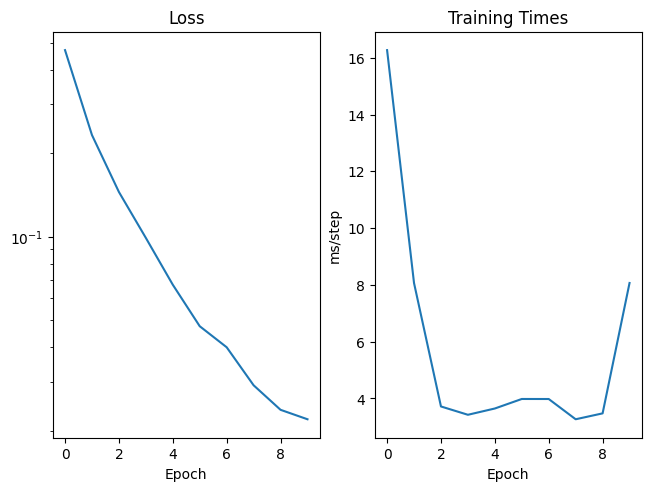

In [141]:
plot_history(history, timings)

**Learnings so far**
* It's fairly easy to implement a completely custom training loop that uses `@tf.function` and gets the same performance.
* `@tf.function` shoudln't be applied at the global level, but just in the main "train step". This balances ease-of-use (ie: using NumPy etc. in callback and tracking logic), without costing any performance (at that high level, you don't gain anything from further graph'izing the logic).
* I get pretty similar looking curves, and similar looking timings, however the loss values are a little different. This might be because somehow I'm using different defaults than used by the out-of-box implementation. Or it might be evidence of an optimization in the out-of-box implementation that are counterproductive for this toy example.

## Out-of-box Implementation Notes
The out-of-box Model.fit() implementation has the equivalent of a @tf.function around a specific sub-part of its processing.

See: tensorflow src > python > keras.enine.training.py > Model

The main part of the fit() contains this block, which is very similar to my first unoptimized train() method:
```python
    def fit():
      ...
      for epoch, iterator in data_handler.enumerate_epochs():
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        with data_handler.catch_stop_iteration():
          for step in data_handler.steps():
            with trace.Trace(
                'train',
                epoch_num=epoch,
                step_num=step,
                batch_size=batch_size,
                _r=1):
              callbacks.on_train_batch_begin(step)
              tmp_logs = self.train_function(iterator)
              if data_handler.should_sync:
                context.async_wait()
              logs = tmp_logs  # No error, now safe to assign to logs.
              end_step = step + data_handler.step_increment
              callbacks.on_train_batch_end(end_step, logs)
              if self.stop_training:
                break
      ...
```

However, that `train_function` is computed and graphed according to `self.make_train_function()`. That wraps up calls to `model.train_step(data)` as either a single call per batch step, or in a loop of `steps_per_execution`, and then compiles the result into graph.

Note that you won't see any `@tf.function` references. Instead you'll see this, which does the same thing:
```python
train_function = def_function.function(train_function, experimental_relax_shapes=True)
```

In the end, the whole training routine is the equivalent of:
```python
@tf.function
def train_step_single(iterator):
  return model.train_step(next(iterator))

@tf.function
def train_step_multiple(iterator):
  for _ in tf.math_ops.range(steps_per_execution):
    outputs = model.train_step(next(iterator))
  return outputs

def fit:
  for epoch in range(epochs):
    for step in range(steps):
      callbacks.on_train_step_begin()
      if steps_per_execution != None:
        outputs = train_step_multiple(batch_iterator)
      else:
        outputs = train_step_single(batch_iterator)
      callbacks.on_train_step_end(outputs)
```

## Polynomial Layer
Let's experiment with the "Polynomial Layer" that I'd earlier experimented with in:
* "OneDrive\Documents\Education\2024-05-03 Machine Learning Specialization\Code\Play - Polynomial_Gradient_Descent.html"

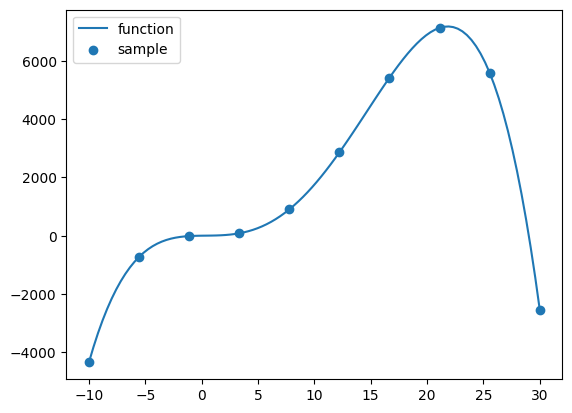

In [2]:
def fx(x):
    return 5*x - 3*x**2 + 3*x**3 - 0.1*x**4

x_train = np.array([np.linspace(-10.0, 30.0, 10)]).reshape(-1,1)
y_train = fx(x_train)
x_detailed = np.linspace(-10.0, 30.0, 100)
fig, ax = plt.subplots()
ax.plot(x_detailed, fx(x_detailed), label='function')
ax.scatter(x_train, y_train, label='sample')
ax.legend()
fig.show()

In [33]:
class Polynomial(tf.keras.layers.Layer):
    def __init__(self, degree=4, regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.degree = degree
        self.regularizer = tf.keras.regularizers.get(regularizer) # interprets named regularizers

    def build(self, input_shape):
        self.add_weight(
            shape=(self.degree+1,),
            initializer="zeros",
            regularizer=self.regularizer,
            trainable=True,
            name="amplitudes"
        )

    def call(self, inputs, training=False):
        sum=None
        for i in range(self.degree+1):
            part=tf.multiply(inputs ** i, tf.gather(self.weights[0], i))
            if sum==None:
                sum = part
            else:
                sum += part
        return sum


In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(
    loss='mse',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)
print(model.summary())

# Note that the scales of things are quite different here.
# In the previous MNIST experiments we had:
#  dataset: 5,000 x 748
#  epochs:  10 @ 157step/epoch                  => 1570 gradient updates
#  total:   10 epochs @ 5,000 samples per epoch => 50,000 training predictions
# Now we have:
#  dataset: 10 x 1
#  epochs: 10,000 @ 1step/epoch => 10,000 gradient updates
#  total:  10,000 x 10          => 100,000 training predictions (note: only twice as many as for the MNIST model)
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10000, verbose=0, callbacks=[timings, LessVerboseEpochLogger(1000)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 poly (Polynomial)           (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch  1000: loss: 113453.0469  
Epoch  2000: loss: 42647.6445  
Epoch  3000: loss: 9777.6152  
Epoch  4000: loss: 1511.1163  
Epoch  5000: loss: 282.0186  
Epoch  6000: loss: 73.4017  
Epoch  7000: loss: 54.9003  
Epoch  8000: loss: 186.4218  
Epoch  9000: loss: 7777.7275  
Epoch 10000: loss: 34.3924  


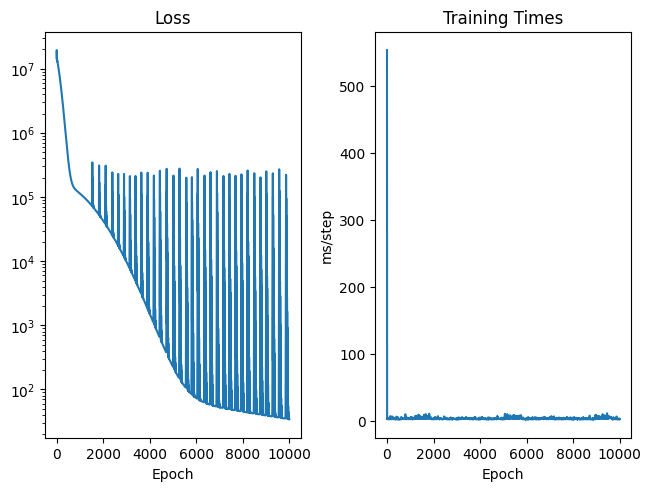

In [19]:
plot_history(history, timings)

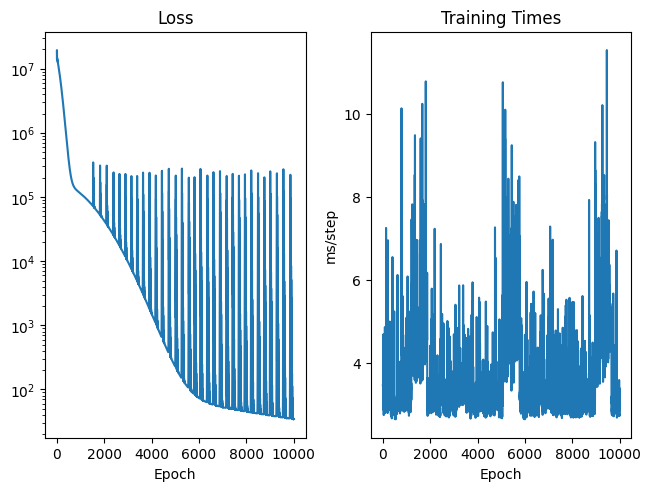

In [22]:
# Apparently the first few epochs went extra slow so let's force their values to the mean and re-plot
timings.timings['epoch_per_step'][0:10] = np.mean(timings.timings['epoch_per_step'][10:])
plot_history(history, timings)

So, it turns out that actually this is correctly executing as a graph. But there are other optimisation issues:
* The learning rate is too high. Furthermore, the default 32 batchSize is breaking up our 100 dataset in a way that doesn't work for this model. So we need to force it to do a train-step every epoch instead of every 32 samples.
* There's no regularization in there yet, and this model would benefit a lot from regularization. In fact, that could well be the cause of the learning rate appearing too high.
* Why is it taking so long on the first epoch?

In [38]:
# First, fixing the batch_size and learning rate issues
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(1000)])

Epoch  1000: loss: 6173349.5000  
Epoch  2000: loss: 2123724.5000  
Epoch  3000: loss: 541619.6250  
Epoch  4000: loss: 157544.3438  
Epoch  5000: loss: 106952.5781  
Epoch  6000: loss: 86167.2266  
Epoch  7000: loss: 64068.1641  
Epoch  8000: loss: 43242.5078  
Epoch  9000: loss: 26170.0312  
Epoch 10000: loss: 13840.8301  


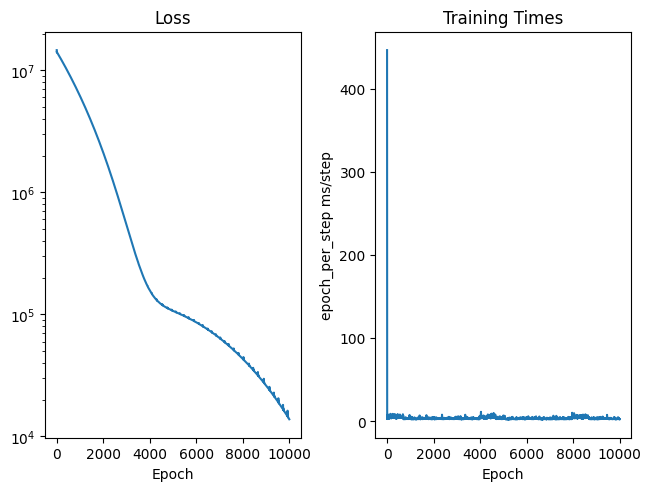

In [39]:
plot_history(history, timings)

Better convergence. But still getting that very slow first epoch. Let's look closer.

In [25]:
# First, fixing the batch_size and learning rate issues
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0], verbose=0, callbacks=[timings])

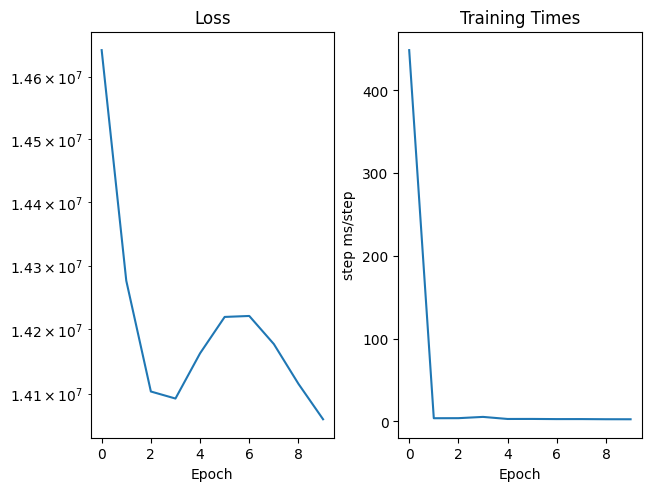

In [27]:
plot_history(history, timings, timings_quantity='step')

Actually, this makes perfect sense. There's only one training step per epoch. So the first epoch is over-scaled by the time it takes to generate the graph on the first run.
I think I'd just be better removing that entry to keep things easy to visualise.

Let's now add the regularization to check that it fixes our last issue.

In [40]:
# Learned weights from previous model
model.get_layer('poly').weights

[<tf.Variable 'poly/amplitudes:0' shape=(5,) dtype=float32, numpy=
 array([-3.570584  ,  3.3288367 , -1.1548587 ,  2.8810544 , -0.09805248],
       dtype=float32)>]

In [35]:
# First, fixing the batch_size and learning rate issues
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4, regularizer=tf.keras.regularizers.l2(0.01))
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(1000)])

Epoch  1000: loss: 6173349.0000  
Epoch  2000: loss: 2123722.7500  
Epoch  3000: loss: 541616.5625  
Epoch  4000: loss: 157543.8906  
Epoch  5000: loss: 107038.8984  
Epoch  6000: loss: 86167.4219  
Epoch  7000: loss: 64123.7578  
Epoch  8000: loss: 43247.3711  
Epoch  9000: loss: 26167.7402  
Epoch 10000: loss: 13839.5176  


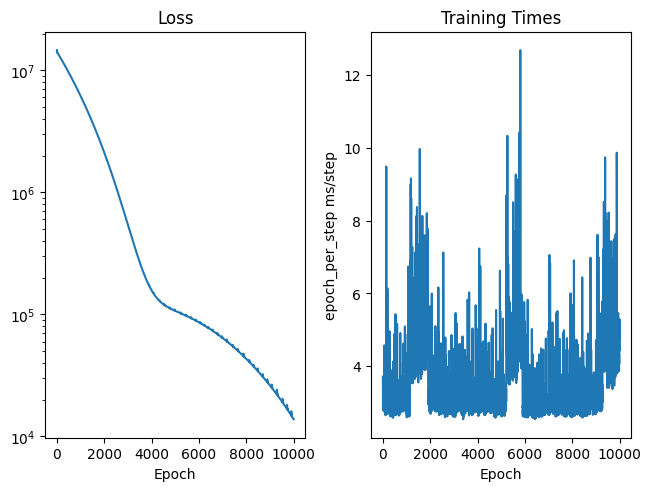

In [37]:
timings.timings['epoch_per_step'][0] = None
plot_history(history, timings)

In [36]:
model.get_layer('poly').weights

[<tf.Variable 'poly/amplitudes:0' shape=(5,) dtype=float32, numpy=
 array([-3.570385  ,  3.32872   , -1.1549165 ,  2.8810809 , -0.09805486],
       dtype=float32)>]

So, that made virtually no difference. It's possible that haven't followed the instructions well enough, and this isn't actually applying any regularization. But more likely is that these values are already coming out correct, as the original polynomial has the same 4th degree characteristic, and the amplitudes that it's finding are very close.

The one last thing that's worth looking into is that the polynomial function might be made more efficient yet. There's some pythonic iteration across the degrees that may not be ideal. Let's first check out the graph:

In [46]:
print(tf.autograph.to_code(model.get_layer('poly').call))

def tf__call(self, inputs, training=None):
    with ag__.FunctionScope('call', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        sum = None

        def get_state_1():
            return (sum,)

        def set_state_1(vars_):
            nonlocal sum
            (sum,) = vars_

        def loop_body(itr):
            nonlocal sum
            i = itr
            part = ag__.converted_call(ag__.ld(tf).multiply, (ag__.ld(inputs) ** ag__.ld(i), ag__.converted_call(ag__.ld(tf).gather, (ag__.ld(self).weights[0], ag__.ld(i)), None, fscope)), None, fscope)

            def get_state():
                return (sum,)

            def set_state(vars_):
                nonlocal sum
                (sum,) = vars_

            def if_body():
                nonlocal sum
                sum = ag__.ld(part)

            def else_body():

In [51]:
poly_as_fn = tf.function(model.get_layer('poly').call)
poly_concrete = poly_as_fn.get_concrete_function(tf.TensorSpec(shape=(None,1), dtype=tf.float32))
print("Signatures: " + poly_as_fn.pretty_printed_concrete_signatures())

Signatures: Input Parameters:
  inputs (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
  training (POSITIONAL_OR_KEYWORD): Literal[False]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135727580740448: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [55]:
graph = poly_concrete.graph
for node in graph.as_graph_def().node:
  print(f'{node.input} -> {node.name}')

[] -> inputs
[] -> pow/y
['inputs', 'pow/y'] -> pow
[] -> Gather/resource
[] -> Gather/indices
['Gather/resource', 'Gather/indices'] -> Gather
['pow', 'Gather'] -> Mul
[] -> pow_1/y
['inputs', 'pow_1/y'] -> pow_1
[] -> Gather_1/indices
['Gather/resource', 'Gather_1/indices'] -> Gather_1
['pow_1', 'Gather_1'] -> Mul_1
['Mul', 'Mul_1'] -> add
[] -> pow_2/y
['inputs', 'pow_2/y'] -> pow_2
[] -> Gather_2/indices
['Gather/resource', 'Gather_2/indices'] -> Gather_2
['pow_2', 'Gather_2'] -> Mul_2
['add', 'Mul_2'] -> add_1
[] -> pow_3/y
['inputs', 'pow_3/y'] -> pow_3
[] -> Gather_3/indices
['Gather/resource', 'Gather_3/indices'] -> Gather_3
['pow_3', 'Gather_3'] -> Mul_3
['add_1', 'Mul_3'] -> add_2
[] -> pow_4/y
['inputs', 'pow_4/y'] -> pow_4
[] -> Gather_4/indices
['Gather/resource', 'Gather_4/indices'] -> Gather_4
['pow_4', 'Gather_4'] -> Mul_4
['add_2', 'Mul_4'] -> add_3
['add_3', '^NoOp'] -> Identity
['^Gather', '^Gather_1', '^Gather_2', '^Gather_3', '^Gather_4'] -> NoOp


In [56]:
print(graph.as_graph_def())

node {
  name: "inputs"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "inputs"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 1
        }
      }
    }
  }
}
node {
  name: "pow/y"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 0.0
      }
    }
  }
}
node {
  name: "pow"
  op: "Pow"
  input: "inputs"
  input: "pow/y"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Gather/resource"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "resource"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      sha

In [71]:
tf.constant(x_train)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[-10.        ],
       [ -5.55555556],
       [ -1.11111111],
       [  3.33333333],
       [  7.77777778],
       [ 12.22222222],
       [ 16.66666667],
       [ 21.11111111],
       [ 25.55555556],
       [ 30.        ]])>

In [110]:
# Let's try a new version
class PolynomialTF(tf.keras.layers.Layer):
    def __init__(self, degree=4, regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.degree = tf.constant(degree, dtype=tf.int32)
        self.regularizer = tf.keras.regularizers.get(regularizer) # interprets named regularizers

    def build(self, input_shape):
        self.add_weight(
            shape=(self.degree+1,),
            initializer="zeros",
            regularizer=self.regularizer,
            trainable=True,
            name="amplitudes"
        )

    def call(self, inputs, training=False):
        print("Calling PolynomialTF") # check for re-tracing and that auto-graph is actually used
        sum=tf.zeros_like(inputs, dtype=inputs.dtype)  # copes with fact that the shape is not known when initially tracing, and with different batch sizes
        for i in tf.range(self.degree+1):
            p = tf.pow(inputs, tf.cast(i, inputs.dtype))         # a simple 'inputs ** i' produces the same results, the problem was that the datatype got mixed up
            sum += tf.multiply(p, tf.gather(self.weights[0], i))
        return sum

# test that it works
polynomialTF = PolynomialTF(4)
polynomialTF(tf.constant(x_train))

Calling PolynomialTF


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [111]:
polynomialTF = PolynomialTF(4)
poly_as_fn = tf.function(polynomialTF)
#poly_as_fn(tf.constant(x_train))

poly_concrete = poly_as_fn.get_concrete_function(tf.constant(x_train))
print("Signatures: " + poly_as_fn.pretty_printed_concrete_signatures())

print()
print("Graph:")
graph = poly_concrete.graph
for node in graph.as_graph_def().node:
  print(f'{node.input} -> {node.name}')

Calling PolynomialTF
Calling PolynomialTF
Signatures: Input Parameters:
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(10, 1), dtype=tf.float64, name=None)
Output Type:
  TensorSpec(shape=(10, 1), dtype=tf.float32, name=None)
Captures:
  135727555930672: TensorSpec(shape=(), dtype=tf.int32, name=None)
  135727816481552: TensorSpec(shape=(), dtype=tf.resource, name=None)

Input Parameters:
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(10, 1), dtype=tf.float64, name=None)
Output Type:
  TensorSpec(shape=(10, 1), dtype=tf.float32, name=None)
Captures:
  135727555930672: TensorSpec(shape=(), dtype=tf.int32, name=None)
  135727816481552: TensorSpec(shape=(), dtype=tf.resource, name=None)

Graph:
[] -> args_0
['args_0'] -> polynomial_tf_40/Cast
[] -> polynomial_tf_40/zeros_like
[] -> polynomial_tf_40/add/y
[] -> polynomial_tf_40/add/x
['polynomial_tf_40/add/x', 'polynomial_tf_40/add/y'] -> polynomial_tf_40/add
[] -> polynomial_tf_40/range/start
[] -> polynomial_tf_40/range/delta
['polynomial_

Calling PolynomialTF
Calling PolynomialTF
Calling PolynomialTF
Epoch  1000: loss: 6173348.0000  
Epoch  2000: loss: 2123722.2500  
Epoch  3000: loss: 541617.1875  
Epoch  4000: loss: 157545.9531  
Epoch  5000: loss: 107430.3516  
Epoch  6000: loss: 86167.0781  
Epoch  7000: loss: 64071.0703  
Epoch  8000: loss: 43247.3594  
Epoch  9000: loss: 26172.0156  
Epoch 10000: loss: 13865.7637  
Total training time: 37.08986806869507 secs


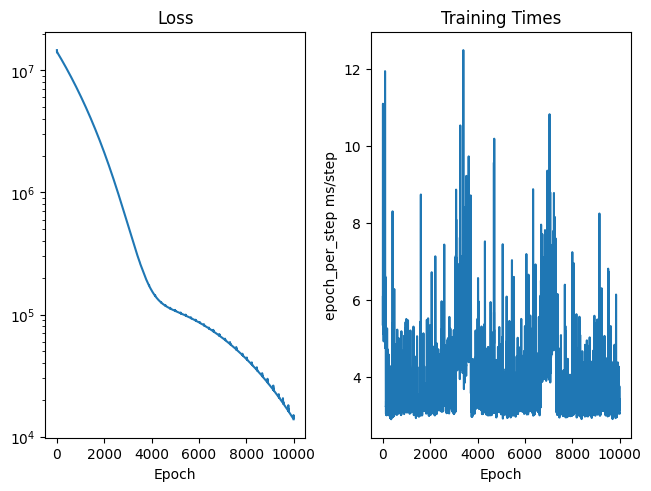

In [141]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    PolynomialTF(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(1000)])
duration = tf.timestamp() - start

timings.timings['epoch_per_step'][0] = None
print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(history, timings)

It's interesting that this ran in comparable time, suggesting that it's no more efficient than the previous implementation. In this case that's not entirely surprising, as an unrolled loop should be equal or more efficient than an explicit loop.

Calling PolynomialTF
Calling PolynomialTF
Calling PolynomialTF
Epoch  1000: loss: 113452.7891  
Epoch  2000: loss: 42596.7773  
Epoch  3000: loss: 9772.2207  
Epoch  4000: loss: 1538.6938  
Epoch  5000: loss: 829.0397  
Epoch  6000: loss: 27590.0938  
Epoch  7000: loss: 73.2157  
Epoch  8000: loss: 53.5542  
Epoch  9000: loss: 39.2556  
Epoch 10000: loss: 38.0260  


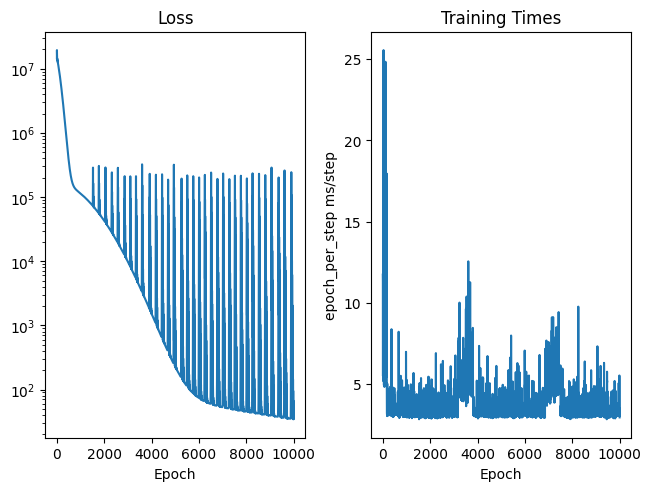

In [113]:
# Before I finish off, what if I set the learning rate higher, now that the batch-size is correct?
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    PolynomialTF(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
timings = timecallback()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(1000)])

timings.timings['epoch_per_step'][0] = None
plot_history(history, timings)

**Learnings:**
* There was actually nothing wrong with the original Polynomial layer. Improvings its TF-ness didn't improve its performance.
* The original problems I had in another notebook (running from within the Coursera system) were that it experienced some other AutoGraph problem that I haven't experienced here.
* All other problems were due to the need to apply the right learning rates, batch-size control etc.

## Batch Size effects on Performance
There's one more thing that would be worth looking at from a performance point of view on the polynomial dataset. 100 data points is a tiny dataset, and its 100x1 total shape is so tiny that we could do more interesting things perhaps. I wouldn't expect anything different if we scaled out our dataset. But let's see what happens anyway.


x_train: (10, 1)
<_BatchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
Calling PolynomialTF
Calling PolynomialTF
Calling PolynomialTF
Epoch     2: loss: 7788172.0000  
Epoch     4: loss: 2877115.5000  
Epoch     6: loss: 794637.0000  
Epoch     8: loss: 202959.8281  
Epoch    10: loss: 113278.2734  
Epoch    12: loss: 91530.2266  
Epoch    14: loss: 69671.6641  
Epoch    16: loss: 48265.3008  
Epoch    18: loss: 30140.7832  
Epoch    20: loss: 16569.2949  
Total training time: 21.66 secs


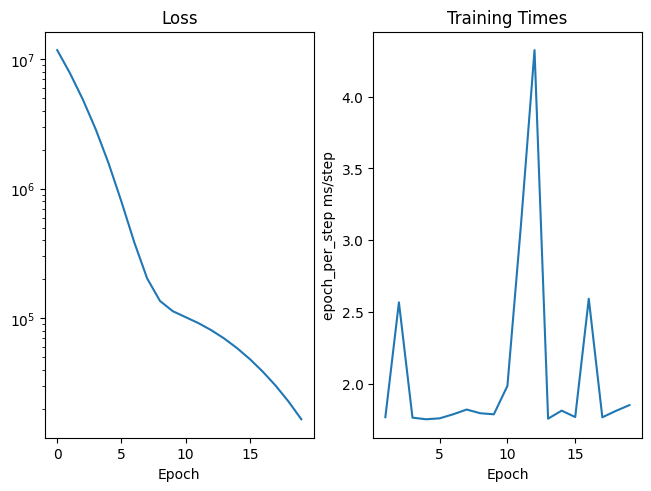

In [146]:
# First, trying to exactly replicate the current training
print(f"x_train: {x_train.shape}")
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat(500).batch(10)
print(ds)

# quick bit of maths:
# previously we had epochs x steps:
#   10,000 x 1 = 10,000
# so new epochs x steps
#   10,000 = 5000/10 x 20 => 20 epochs
#   10,000 = 5000/32 x 64 => 64 epochs
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    PolynomialTF(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
start = tf.timestamp()
history = model.fit(ds, epochs=20, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(2)])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

timings.timings['epoch_per_step'][0] = None
plot_history(history, timings)

Just with that alone, it looks like we're getting better training times. However, this may be an averaging effect. It's quite likely that our prior results would look if we downsampled-via-averaging to the same resolution.

Calling PolynomialTF
Calling PolynomialTF
Calling PolynomialTF
Epoch     6: loss: 7205629.0000  
Epoch    12: loss: 2894619.5000  
Epoch    18: loss: 908299.2500  
Epoch    24: loss: 249954.7188  
Epoch    30: loss: 123700.3125  
Epoch    36: loss: 100556.5625  
Epoch    42: loss: 80666.6484  
Epoch    48: loss: 60664.4023  
Epoch    54: loss: 42823.9023  
Epoch    60: loss: 28437.1172  
Total training time: 25.12 secs


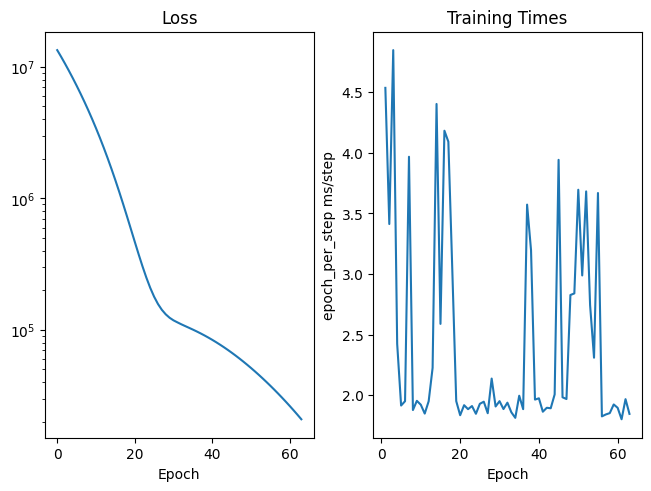

In [144]:
# Now the same, but 32 batch-size, creating a sort of randomness (64 epochs in order to keep same number of training steps)
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat(500).batch(32)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    PolynomialTF(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
start = tf.timestamp()
history = model.fit(ds, epochs=64, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(6)])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
timings.timings['epoch_per_step'][0] = None
plot_history(history, timings)

Calling PolynomialTF
Calling PolynomialTF
Calling PolynomialTF
Epoch     6: loss: 10331410.0000  
Epoch    12: loss: 7015801.5000  
Epoch    18: loss: 4631930.0000  
Epoch    24: loss: 2786609.0000  
Epoch    30: loss: 1568612.6250  
Epoch    36: loss: 806563.0000  
Epoch    42: loss: 388161.3125  
Epoch    48: loss: 212633.2344  
Epoch    54: loss: 154927.9688  
Epoch    60: loss: 127487.1328  
Total training time: 24.73 secs


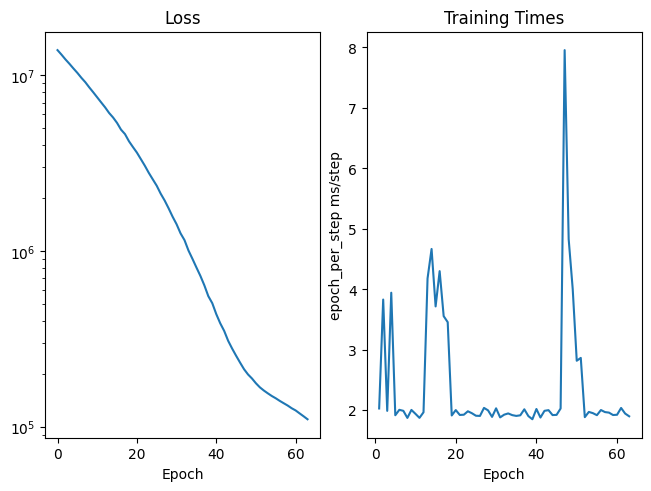

In [145]:
# Now with explicit randomness
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat(500).shuffle(5000).batch(32)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    PolynomialTF(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
timings = timecallback()
start = tf.timestamp()
history = model.fit(ds, epochs=64, batch_size=x_train.shape[0], verbose=0, callbacks=[timings, LessVerboseEpochLogger(6)])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
timings.timings['epoch_per_step'][0] = None
plot_history(history, timings)

That's actually noticeably worse. And I get the same basic result each time I rerun it.

**Lessons**:
* In some cases there will be a benefit to the Dataset+repeating approach where shuffling the data produces an extra bit of stochastic-ness to the training that helps avoid local minima.
* However, from a pure performance point of view it doesn't add anything.